In [1]:
import pandas as pd

weather = pd.read_csv("3727350.csv", index_col="DATE")


In [2]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]

In [3]:
valid_columns = weather.columns[null_pct < 0.25]

In [4]:
weather = weather[valid_columns].copy()

In [5]:
weather.columns = weather.columns.str.lower()

In [6]:
weather = weather.ffill()

In [7]:
weather.apply(pd.isnull).sum()

station      0
name         0
tavg       669
tmax       672
dtype: int64

In [8]:
weather = weather.ffill()

In [9]:
weather.apply(pd.isnull).sum()

station      0
name         0
tavg       669
tmax       672
dtype: int64

In [10]:
weather.index

Index(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04', '1970-01-05',
       '1970-01-06', '1970-01-07', '1970-01-08', '1970-01-09', '1970-01-10',
       ...
       '1970-12-22', '1970-12-23', '1970-12-24', '1970-12-25', '1970-12-26',
       '1970-12-27', '1970-12-28', '1970-12-29', '1970-12-30', '1970-12-31'],
      dtype='object', name='DATE', length=21383)

In [11]:
weather.index = pd.to_datetime(weather.index)

In [12]:
weather.index.year.value_counts().sort_index()

DATE
1970    3164
1973     340
1974     355
1975     365
1976     354
1977     365
1978     365
1979     365
1980     366
1981     365
1982     365
1983     365
1984     366
1985     365
1986     361
1987     363
1988     358
1989     363
1990     344
1991     350
1992     360
1993     358
1994     360
1995     364
1996     362
1997     361
1998     352
1999     357
2000     360
2001     360
2002     361
2003     364
2004     364
2005     365
2006     365
2007     361
2008     365
2009     362
2010     358
2011     364
2012     366
2014     364
2015     365
2016     366
2017     359
2018     361
2019     357
2020     366
2021     361
2022     357
2023     365
2024     169
Name: count, dtype: int64

In [13]:
weather = weather[weather.index.year != 1970]
weather.to_csv('weather_updated.csv', index=False)

In [14]:
weather = weather.ffill()

In [15]:
weather.apply(pd.isnull).sum()

station    0
name       0
tavg       0
tmax       3
dtype: int64

In [16]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

In [17]:
predictors

Index(['tavg', 'tmax'], dtype='object')

In [18]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions= []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])

        preds = model.predict(test[predictors])

        preds = pd.Series(preds, index = test.index)
        combined = pd.concat([test["target"], preds], axis=1)

        combined.columns = ["actual", "prediction"]

        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [19]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha = .1)

In [20]:
weather["target"] = weather.shift(-1)["tmax"]

In [21]:
weather

,station,name,tavg,tmax,target
DATE,,,,,
1973-01-01,IN019131301,"JAIPUR SANGANER, IN",54.0,NaN,NaN
1973-01-02,IN019131301,"JAIPUR SANGANER, IN",59.0,NaN,NaN
1973-01-03,IN019131301,"JAIPUR SANGANER, IN",55.0,NaN,77.0
1973-01-04,IN019131301,"JAIPUR SANGANER, IN",62.0,77.0,79.0
1973-01-05,IN019131301,"JAIPUR SANGANER, IN",69.0,79.0,81.0
...,...,...,...,...,...
2024-06-18,IN019131301,"JAIPUR SANGANER, IN",100.0,110.0,109.0
2024-06-19,IN019131301,"JAIPUR SANGANER, IN",98.0,109.0,107.0
2024-06-20,IN019131301,"JAIPUR SANGANER, IN",86.0,107.0,100.0


In [22]:
weather = weather[weather.index.year != 1973]
weather.to_csv('weather_updated.csv', index=False)

In [23]:
weather = weather[weather.index.year != 2024]
weather.to_csv('weather_updated.csv', index=False)

In [24]:
weather

,station,name,tavg,tmax,target
DATE,,,,,
1974-01-01,IN019131301,"JAIPUR SANGANER, IN",58.0,75.0,77.0
1974-01-02,IN019131301,"JAIPUR SANGANER, IN",55.0,77.0,77.0
1974-01-03,IN019131301,"JAIPUR SANGANER, IN",63.0,77.0,79.0
1974-01-04,IN019131301,"JAIPUR SANGANER, IN",60.0,79.0,77.0
1974-01-05,IN019131301,"JAIPUR SANGANER, IN",61.0,77.0,73.0
...,...,...,...,...,...
2023-12-27,IN019131301,"JAIPUR SANGANER, IN",65.0,80.0,79.0
2023-12-28,IN019131301,"JAIPUR SANGANER, IN",62.0,79.0,77.0
2023-12-29,IN019131301,"JAIPUR SANGANER, IN",56.0,77.0,72.0


In [25]:
predictions = backtest(weather, rr, predictors)

In [26]:
predictions

,actual,prediction,diff
DATE,,,
1984-01-21,66.0,70.479131,4.479131
1984-01-22,69.0,67.954791,1.045209
1984-01-23,68.0,69.957051,1.957051
1984-01-24,71.0,69.652978,1.347022
1984-01-25,71.0,71.437229,0.437229
...,...,...,...
2023-12-27,79.0,79.636171,0.636171
2023-12-28,77.0,78.139409,1.139409
2023-12-29,72.0,75.145885,3.145885


In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions["actual"], predictions["prediction"])

np.float64(1.7712100549562488)

In [28]:
predictions["diff"].mean()

np.float64(1.7712100549562488)

In [29]:
def pct_diff(old, new):
    return (new-old)/old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"

    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather

rolling_horizons = [3,14]

for horizon in rolling_horizons:
    for col in ["tmax", "tavg", ]:
        weather = compute_rolling(weather, horizon, col)

In [30]:
weather


,station,name,tavg,tmax,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tavg,rolling_3_tavg_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tavg,rolling_14_tavg_pct
DATE,,,,,,,,,,,,,
1974-01-01,IN019131301,"JAIPUR SANGANER, IN",58.0,75.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-01-02,IN019131301,"JAIPUR SANGANER, IN",55.0,77.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-01-03,IN019131301,"JAIPUR SANGANER, IN",63.0,77.0,79.0,76.333333,0.008734,58.666667,0.073864,NaN,NaN,NaN,NaN
1974-01-04,IN019131301,"JAIPUR SANGANER, IN",60.0,79.0,77.0,77.666667,0.017167,59.333333,0.011236,NaN,NaN,NaN,NaN
1974-01-05,IN019131301,"JAIPUR SANGANER, IN",61.0,77.0,73.0,77.666667,-0.008584,61.333333,-0.005435,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,IN019131301,"JAIPUR SANGANER, IN",65.0,80.0,79.0,78.000000,0.025641,64.333333,0.010363,77.142857,0.037037,63.714286,0.020179
2023-12-28,IN019131301,"JAIPUR SANGANER, IN",62.0,79.0,77.0,78.666667,0.004237,64.000000,-0.031250,77.214286,0.023127,63.500000,-0.023622
2023-12-29,IN019131301,"JAIPUR SANGANER, IN",56.0,77.0,72.0,78.666667,-0.021186,61.000000,-0.081967,77.142857,-0.001852,62.928571,-0.110102


In [31]:
weather = weather.iloc[14:,:]

In [32]:
weather

,station,name,tavg,tmax,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tavg,rolling_3_tavg_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tavg,rolling_14_tavg_pct
DATE,,,,,,,,,,,,,
1974-01-15,IN019131301,"JAIPUR SANGANER, IN",51.0,64.0,68.0,67.666667,-0.054187,54.000000,-0.055556,73.857143,-0.133462,58.500000,-0.128205
1974-01-16,IN019131301,"JAIPUR SANGANER, IN",54.0,68.0,72.0,66.000000,0.030303,52.666667,0.025316,73.214286,-0.071220,58.428571,-0.075795
1974-01-17,IN019131301,"JAIPUR SANGANER, IN",61.0,72.0,73.0,68.000000,0.058824,55.333333,0.102410,72.857143,-0.011765,58.285714,0.046569
1974-01-18,IN019131301,"JAIPUR SANGANER, IN",63.0,73.0,73.0,71.000000,0.028169,59.333333,0.061798,72.428571,0.007890,58.500000,0.076923
1974-01-19,IN019131301,"JAIPUR SANGANER, IN",63.0,73.0,73.0,72.666667,0.004587,62.333333,0.010695,72.142857,0.011881,58.642857,0.074300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,IN019131301,"JAIPUR SANGANER, IN",65.0,80.0,79.0,78.000000,0.025641,64.333333,0.010363,77.142857,0.037037,63.714286,0.020179
2023-12-28,IN019131301,"JAIPUR SANGANER, IN",62.0,79.0,77.0,78.666667,0.004237,64.000000,-0.031250,77.214286,0.023127,63.500000,-0.023622
2023-12-29,IN019131301,"JAIPUR SANGANER, IN",56.0,77.0,72.0,78.666667,-0.021186,61.000000,-0.081967,77.142857,-0.001852,62.928571,-0.110102


In [33]:
weather = weather.fillna(0)

In [34]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tavg"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys = False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys = False).apply(expand_mean)


In [35]:
weather

,station,name,tavg,tmax,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tavg,rolling_3_tavg_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tavg,rolling_14_tavg_pct,month_avg_tmax,day_avg_tmax,month_avg_tavg,day_avg_tavg
DATE,,,,,,,,,,,,,,,,,
1974-01-15,IN019131301,"JAIPUR SANGANER, IN",51.0,64.0,68.0,67.666667,-0.054187,54.000000,-0.055556,73.857143,-0.133462,58.500000,-0.128205,64.000000,64.000000,51.000000,51.000000
1974-01-16,IN019131301,"JAIPUR SANGANER, IN",54.0,68.0,72.0,66.000000,0.030303,52.666667,0.025316,73.214286,-0.071220,58.428571,-0.075795,66.000000,68.000000,52.500000,54.000000
1974-01-17,IN019131301,"JAIPUR SANGANER, IN",61.0,72.0,73.0,68.000000,0.058824,55.333333,0.102410,72.857143,-0.011765,58.285714,0.046569,68.000000,72.000000,55.333333,61.000000
1974-01-18,IN019131301,"JAIPUR SANGANER, IN",63.0,73.0,73.0,71.000000,0.028169,59.333333,0.061798,72.428571,0.007890,58.500000,0.076923,69.250000,73.000000,57.250000,63.000000
1974-01-19,IN019131301,"JAIPUR SANGANER, IN",63.0,73.0,73.0,72.666667,0.004587,62.333333,0.010695,72.142857,0.011881,58.642857,0.074300,70.000000,73.000000,58.400000,63.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,IN019131301,"JAIPUR SANGANER, IN",65.0,80.0,79.0,78.000000,0.025641,64.333333,0.010363,77.142857,0.037037,63.714286,0.020179,76.762126,74.291667,62.047176,60.104167
2023-12-28,IN019131301,"JAIPUR SANGANER, IN",62.0,79.0,77.0,78.666667,0.004237,64.000000,-0.031250,77.214286,0.023127,63.500000,-0.023622,76.763612,73.734694,62.047145,59.408163
2023-12-29,IN019131301,"JAIPUR SANGANER, IN",56.0,77.0,72.0,78.666667,-0.021186,61.000000,-0.081967,77.142857,-0.001852,62.928571,-0.110102,76.763769,73.612245,62.043132,58.938776


In [36]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

In [37]:
predictors


Index(['tavg', 'tmax', 'rolling_3_tmax', 'rolling_3_tmax_pct',
       'rolling_3_tavg', 'rolling_3_tavg_pct', 'rolling_14_tmax',
       'rolling_14_tmax_pct', 'rolling_14_tavg', 'rolling_14_tavg_pct',
       'month_avg_tmax', 'day_avg_tmax', 'month_avg_tavg', 'day_avg_tavg'],
      dtype='object')

In [38]:
predictions = backtest(weather, rr, predictors)

In [39]:
mean_absolute_error(predictions["actual"], predictions["prediction"])

np.float64(1.7288541609312023)

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='diff'>

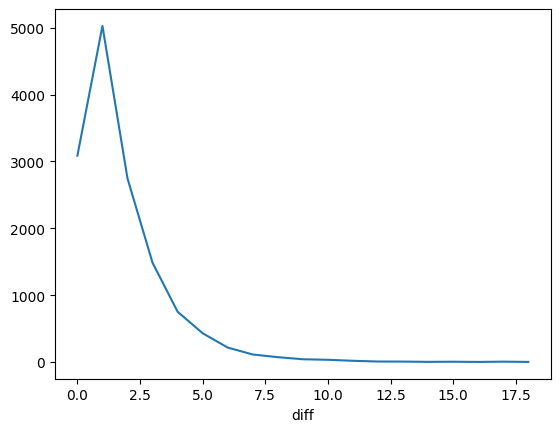

In [40]:
predictions["diff"].round().value_counts().sort_index().plot()

In [41]:
import matplotlib

In [42]:
import matplotlib

In [43]:
import matplotlib.pyplot as pld